In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

# List kaggle folders

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./JUGE_Vincent_documentation_et_code_112022.ipynb
./output.png
./JUGE_Vincent_presentation_112022.pdf
./JUGE_Vincent_lien_kernel_kaggle_112022.txt
./index.md
./submission.csv
./module-p8.ipynb
./JUGE_Vincent_Rapport_112022.pdf
./JUGE_Vincent_P8_112022.zip
./diagram.drawio.png
./data/stores.csv
./data/oil.csv
./data/transactions.csv
./data/holidays_events.csv
./data/train.csv
./data/train_filled.csv
./data/train.csv.gz
./data/test.csv
./data/sample_submission.csv


In [3]:
#!pip install "gluonts[mxnet,pro]"

In [4]:
# desactivate removal of outliers and scaling of data, since it gives worste results

REMOVE_OUTLIERS = False
SCALE_DATA = False

## EDA

In [5]:
from datetime import datetime

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test.date.min()
df_test.date.max()
min = datetime.strptime(df_test.date.min(), '%Y-%M-%d')
max = datetime.strptime(df_test.date.max(), '%Y-%M-%d')




'2017-08-16'

'2017-08-31'

In [6]:
df_train
df_train.shape
df_train.date.min()
df_train.date.max()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


(3000888, 6)

'2013-01-01'

'2017-08-15'

dataset starts from 2013-01-01 to 2017-08-15

predictions must be made from 2017-08-16 to 2017-08-31


In [7]:
df_train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

Do we have continuous dates ?

no : 25 december is missing for all


In [8]:
df_train.groupby(by=['date']).count()

df_train[df_train['date'] == '2013-12-24']
df_train[df_train['date'] == '2013-12-25']

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,1782,1782,1782,1782,1782
2013-01-02,1782,1782,1782,1782,1782
2013-01-03,1782,1782,1782,1782,1782
2013-01-04,1782,1782,1782,1782,1782
2013-01-05,1782,1782,1782,1782,1782
...,...,...,...,...,...
2017-08-11,1782,1782,1782,1782,1782
2017-08-12,1782,1782,1782,1782,1782
2017-08-13,1782,1782,1782,1782,1782


,id,date,store_nbr,family,sales,onpromotion
636174,636174,2013-12-24,1,AUTOMOTIVE,1.000,0
636175,636175,2013-12-24,1,BABY CARE,0.000,0
636176,636176,2013-12-24,1,BEAUTY,2.000,0
636177,636177,2013-12-24,1,BEVERAGES,1248.000,0
636178,636178,2013-12-24,1,BOOKS,0.000,0
...,...,...,...,...,...,...
637951,637951,2013-12-24,9,POULTRY,848.844,0
637952,637952,2013-12-24,9,PREPARED FOODS,40.000,0
637953,637953,2013-12-24,9,PRODUCE,0.000,0
637954,637954,2013-12-24,9,SCHOOL AND OFFICE SUPPLIES,0.000,0


,id,date,store_nbr,family,sales,onpromotion


### Fill missing dates


On each December 25, for each store and each category, set 'sales' to 0



In [9]:
# add missing dates to train dataset : required for fitting the model

un_store = df_train['store_nbr'].unique()
un_family = df_train['family'].unique()

tmp_df = pd.DataFrame(
    columns=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'],
    )

for i, s in enumerate(un_store):
    for j, f in enumerate(un_family):
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2013-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True,
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2014-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2015-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2016-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )

tmp_df
df_train = df_train.append(tmp_df)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-12-25,1,AUTOMOTIVE,0,0
1,0,2014-12-25,1,AUTOMOTIVE,0,0
2,0,2015-12-25,1,AUTOMOTIVE,0,0
3,0,2016-12-25,1,AUTOMOTIVE,0,0
4,0,2013-12-25,1,BABY CARE,0,0
...,...,...,...,...,...,...
7123,0,2016-12-25,9,SCHOOL AND OFFICE SUPPLIES,0,0
7124,0,2013-12-25,9,SEAFOOD,0,0
7125,0,2014-12-25,9,SEAFOOD,0,0
7126,0,2015-12-25,9,SEAFOOD,0,0


In [10]:
df_train = df_train.astype({
    'id': 'int64',
    'store_nbr': 'int64',
    'sales': 'float',
    'onpromotion': 'int64'
})
# df_train.to_csv('data/train_filled.csv')


### Exceptional Events

In [11]:
df_oil = pd.read_csv('./data/oil.csv')

In [12]:
df_train = pd.merge(df_train, df_oil, how= 'left', on='date', )
df_train['dcoilwtico'].fillna(0, inplace=True)
df_train


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0
...,...,...,...,...,...,...,...
3008011,0,2016-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0,0.0
3008012,0,2013-12-25,9,SEAFOOD,0.0,0,0.0
3008013,0,2014-12-25,9,SEAFOOD,0.0,0,0.0
3008014,0,2015-12-25,9,SEAFOOD,0.0,0,0.0


### Categorical Values 


Eventually encode categorical feature, maybe usefull for the model

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train['family_cat'] = le.fit_transform(df_train['family'])
le.classes_
len(le.classes_)

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR WINE BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

33

In [14]:
df_test['family_cat'] = le.fit_transform(df_test['family'])
df_test

,id,date,store_nbr,family,onpromotion,family_cat
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,1
2,3000890,2017-08-16,1,BEAUTY,2,2
3,3000891,2017-08-16,1,BEVERAGES,20,3
4,3000892,2017-08-16,1,BOOKS,0,4
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,28
28508,3029396,2017-08-31,9,PREPARED FOODS,0,29
28509,3029397,2017-08-31,9,PRODUCE,1,30
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,31


### Data Preparation


In [15]:
nb_stores = df_train['store_nbr'].unique()
nb_stores
len(nb_stores)

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

54


#### Outliers

(Optionnal) : remove outliers of dataset.

note: if activated, submission to kaggle gives worse result than without

In [16]:
def dropOutlierIQR(df, col):
    """removes outliers of dataframe following IQR method, and set the value to median

    Args:
        df (pandas.Dataframe): dataframe
        col (string): column to remove outliers
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    med = np.median(df[col])
    df[col] = df[col].apply(lambda x: x if ((x > (Q1 - 1.5 * IQR)) & (x < (Q3 + 1.5 * IQR))) else med)
    return df


In [17]:
# apply to all catagories
import matplotlib.pyplot as plt

# desactivate
if REMOVE_OUTLIERS : 
    for cat in le.classes_:
        df_tmp = df_train[df_train['family'] == cat]
        df_train[df_train['family'] == cat] = dropOutlierIQR(df_tmp, 'sales')


<AxesSubplot:title={'center':'sales'}, xlabel='family'>

<AxesSubplot:title={'center':'sales'}, xlabel='family'>

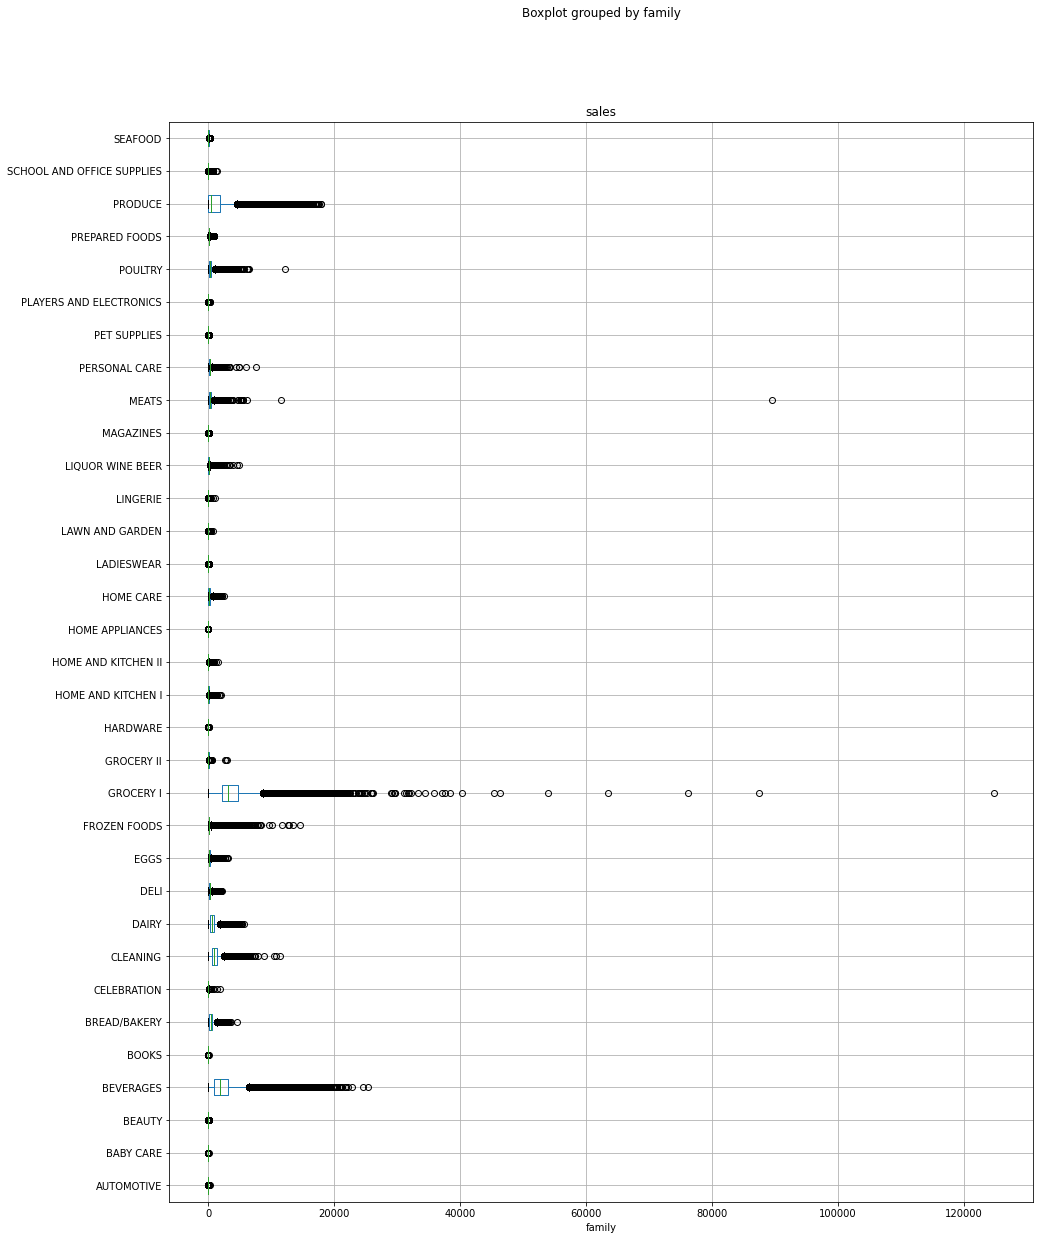

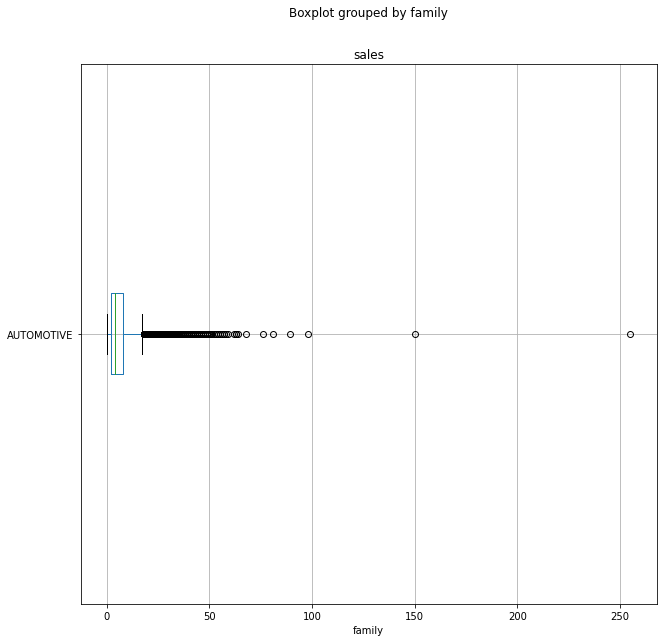

In [18]:

df_train.boxplot(column=['sales'], by='family', vert=False, figsize=(15,20))
df_train[df_train['family'] == 'AUTOMOTIVE'].boxplot(column=['sales'], by='family', vert=False, figsize=(10,10))



#### Scaling

Apply MinMax Scaler to each family

In [19]:
from sklearn.preprocessing import MinMaxScaler

def fit_all_scalers(df, col, target):
    """scale dataframe and returns scaler following a given category

    Args:
        df (pandas.Dataframe): dataframe to scale
        col (string): column of the categories to filter dataframe
        target (string): target column to scale, following the category

    Returns:
        _type_: dict of scalers for each category
    """
    categories = np.unique(df[col])
    scalers = []
    for cat in categories:
        scaler = MinMaxScaler()
        to_scale = df[df[col] == cat][target]
        df.loc[df[col] == cat, target] = scaler.fit_transform(np.array(to_scale).reshape(-1,1))
        scalers.append({col: cat, 'scaler': scaler})
    return scalers

def unscale(df, scalers, col, target):
    categories = np.unique(df[col])
    for cat in categories:
        scaler = [item for item in scalers if item['family'] == cat][0]['scaler']
        to_scale = df[df[col] == cat][target]
        df.loc[df[col] == cat, target] = scaler.inverse_transform(np.array(to_scale).reshape(-1,1))


In [20]:
# desactivate
if SCALE_DATA: 
    scalers = fit_all_scalers(df_train, 'family', 'sales')
    scalers


In [21]:
df_train[df_train['sales'] != 0]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,family_cat
563,563,2013-01-01,25,BEAUTY,2.000,0,0.00,2
564,564,2013-01-01,25,BEVERAGES,810.000,0,0.00,3
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0,0.00,5
568,568,2013-01-01,25,CLEANING,186.000,0,0.00,7
569,569,2013-01-01,25,DAIRY,143.000,0,0.00,8
...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,28
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,29
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,30
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,31


### Set Index to be the date

Required for the model below


In [22]:
df_train.set_index('date', inplace=True)
df_train.sort_index(inplace=True)

In [23]:
df_test.set_index('date', inplace=True)
df_test

,id,store_nbr,family,onpromotion,family_cat
date,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,0
2017-08-16,3000889,1,BABY CARE,0,1
2017-08-16,3000890,1,BEAUTY,2,2
2017-08-16,3000891,1,BEVERAGES,20,3
2017-08-16,3000892,1,BOOKS,0,4
...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1,28
2017-08-31,3029396,9,PREPARED FOODS,0,29
2017-08-31,3029397,9,PRODUCE,1,30


In [24]:
df_test['sales'] = 0

In [25]:
df_train.loc['2013-12-25']

,id,store_nbr,family,sales,onpromotion,dcoilwtico,family_cat
date,,,,,,,
2013-12-25,0,41,PREPARED FOODS,0.0,0,0.0,29
2013-12-25,0,42,BOOKS,0.0,0,0.0,4
2013-12-25,0,42,BEVERAGES,0.0,0,0.0,3
2013-12-25,0,42,BEAUTY,0.0,0,0.0,2
2013-12-25,0,42,BABY CARE,0.0,0,0.0,1
...,...,...,...,...,...,...,...
2013-12-25,0,25,PET SUPPLIES,0.0,0,0.0,26
2013-12-25,0,25,PERSONAL CARE,0.0,0,0.0,25
2013-12-25,0,26,BEVERAGES,0.0,0,0.0,3


In [26]:
df_train

,id,store_nbr,family,sales,onpromotion,dcoilwtico,family_cat
date,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,0.00,0
2013-01-01,1194,42,CELEBRATION,0.000,0,0.00,6
2013-01-01,1193,42,BREAD/BAKERY,0.000,0,0.00,5
2013-01-01,1192,42,BOOKS,0.000,0,0.00,4
2013-01-01,1191,42,BEVERAGES,0.000,0,0.00,3
...,...,...,...,...,...,...,...
2017-08-15,2999695,25,POULTRY,172.517,0,47.57,28
2017-08-15,2999694,25,PLAYERS AND ELECTRONICS,3.000,0,47.57,27
2017-08-15,2999693,25,PET SUPPLIES,3.000,0,47.57,26


In [27]:
df_test.groupby(by=['store_nbr', 'family']).count()

id  onpromotion  family_cat  sales
store_nbr family                                                        
1         AUTOMOTIVE                  16           16          16     16
          BABY CARE                   16           16          16     16
          BEAUTY                      16           16          16     16
          BEVERAGES                   16           16          16     16
          BOOKS                       16           16          16     16
...                                   ..          ...         ...    ...
54        POULTRY                     16           16          16     16
          PREPARED FOODS              16           16          16     16
          PRODUCE                     16           16          16     16
          SCHOOL AND OFFICE SUPPLIES  16           16          16     16
          SEAFOOD                     16           16          16     16

[1782 rows x 4 columns]

The prediction length is for 16 days

## GluonTS

In [28]:
from gluonts.dataset.common import ListDataset
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.pandas import PandasDataset


from gluonts.mx import Trainer

freq = "D"

context_length = 2000 # train on this number of points
prediction_length = 16 # see prediction lenght infered above, corresponds to the number of days from 2017-08-15 to 2017-08-31

In [29]:
# number of points to predict is actually the length of the test dataset for each store and each poduct familly
df_test.groupby(by=['store_nbr', 'family']).count()

id  onpromotion  family_cat  sales
store_nbr family                                                        
1         AUTOMOTIVE                  16           16          16     16
          BABY CARE                   16           16          16     16
          BEAUTY                      16           16          16     16
          BEVERAGES                   16           16          16     16
          BOOKS                       16           16          16     16
...                                   ..          ...         ...    ...
54        POULTRY                     16           16          16     16
          PREPARED FOODS              16           16          16     16
          PRODUCE                     16           16          16     16
          SCHOOL AND OFFICE SUPPLIES  16           16          16     16
          SEAFOOD                     16           16          16     16

[1782 rows x 4 columns]

#### Dataset Preparation

#### One Store

Since our dataset is a multivariate time series : date + store_nbr + family, and since our model below doesn't accepts more than one extra category (for multivariate datasets),
we want to split the training and predictions for each store_nbr. Otherwise the dataset is considered inconsistent

GluonTs accepts a specific format of dataset, which can be created from panda dataframe, but must follow a strict content.

let's try to do for one store only, first :

In [30]:
#
df = df_train [['store_nbr', 'family', 'sales', 'id', 'onpromotion', 'dcoilwtico']]
df = df [df['store_nbr'] == 1]
df = df.astype({'store_nbr': 'string', 'family':'string', 'sales': 'int', 'onpromotion': 'int', 'dcoilwtico': 'float'})
df.dtypes
df

store_nbr       string
family          string
sales            int64
id               int64
onpromotion      int64
dcoilwtico     float64
dtype: object

,store_nbr,family,sales,id,onpromotion,dcoilwtico
date,,,,,,
2013-01-01,1,AUTOMOTIVE,0,0,0,0.00
2013-01-01,1,MAGAZINES,0,23,0,0.00
2013-01-01,1,LIQUOR WINE BEER,0,22,0,0.00
2013-01-01,1,LINGERIE,0,21,0,0.00
2013-01-01,1,LAWN AND GARDEN,0,20,0,0.00
...,...,...,...,...,...,...
2017-08-15,1,SEAFOOD,22,2999138,0,47.57
2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0,2999137,0,47.57
2017-08-15,1,PRODUCE,2240,2999136,7,47.57


In [31]:
np.unique(df['family']).size

33

In [32]:
# generate GluonTs Dataset

ds = PandasDataset.from_long_dataframe(df, freq='d', target='sales', item_id=['family'])


#### All Stores

do the same dataset preparation for all the 'nb_stores' stores

In [33]:
all_stores_ds = []

for store in nb_stores:
    df_tmp = df_train [['store_nbr', 'family', 'sales', 'id']]
    df_tmp = df_tmp [df_tmp['store_nbr'] == store]
    df_tmp = df_tmp.astype({'store_nbr': 'string', 'family':'string', 'sales': 'int'})
    ds_tmp = PandasDataset.from_long_dataframe(df_tmp, freq='d', target='sales', item_id='family')
    all_stores_ds.append({'store_nbr': store, 'ds': ds_tmp})

# all_stores_ds

In [34]:
all_stores_ds[0]['store_nbr']
all_stores_ds[0]['ds']


1

PandasDataset(dataframes={'AUTOMOTIVE':            store_nbr      family  sales       id
date                                            
2013-01-01         1  AUTOMOTIVE      0        0
2013-01-02         1  AUTOMOTIVE      2     1782
2013-01-03         1  AUTOMOTIVE      3     3564
2013-01-04         1  AUTOMOTIVE      3     5346
2013-01-05         1  AUTOMOTIVE      5     7128
...              ...         ...    ...      ...
2017-08-11         1  AUTOMOTIVE      1  2991978
2017-08-12         1  AUTOMOTIVE      6  2993760
2017-08-13         1  AUTOMOTIVE      1  2995542
2017-08-14         1  AUTOMOTIVE      1  2997324
2017-08-15         1  AUTOMOTIVE      4  2999106

[1688 rows x 4 columns], 'BABY CARE':            store_nbr     family  sales       id
date                                           
2013-01-01         1  BABY CARE      0        1
2013-01-02         1  BABY CARE      0     1783
2013-01-03         1  BABY CARE      0     3565
2013-01-04         1  BABY CARE      0     5

#### Model Training

In [35]:
from gluonts.evaluation import make_evaluation_predictions

def show_predictor(predictor, _ds):
    """plots the prediction

    Args:
        predictor (_type_): gluonTs predictor 
        _ds (_type_): gluonTs dataset
    """
    prediction = next(predictor.predict(_ds))
    print(prediction.mean)
    prediction.plot()

def get_forecasts(_ds):
    """gets forecasts for the given dataset

    Args:
        _ds (_type_): gluonTs dataset, contains the train and test data + prediction range

    Returns:
        _type_: tss and forecasts, two gluonTs forecasts structures
    """

    estimator = DeepAREstimator(
        freq=_ds.freq, 
        prediction_length=prediction_length, 
        trainer=Trainer(
            epochs=5,
            learning_rate=1e-3,
            num_batches_per_epoch=10,
            patience=2
            )
    )
    predictor = estimator.train(_ds)
    # show_predictor(predictor, _ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=10,  # number of sample paths we want for evaluation
    )
    tss = list(ts_it)
    forecasts = list(forecast_it)
    return tss, forecasts



In [36]:
def get_all_datastores(_all_stores_ds):
    """get forecasts for datastores

    Args:
        _all_stores_ds (_type_): array containing datastores to forecast
    """
    all_stores_forecasts = []
    for ds in _all_stores_ds:
        store_nbr = ds['store_nbr']
        ds = ds['ds']
        tss, forecasts = get_forecasts(ds)
        all_stores_forecasts.append({'store_nbr':store_nbr, 'tss': tss, 'forecasts': forecasts})
    return all_stores_forecasts

all_stores_forecasts = get_all_datastores(all_stores_ds)

100%|██████████| 10/10 [00:00<00:00, 21.45it/s, epoch=5/5, avg_epoch_loss=4.57]


In [37]:
# check results

# all_stores_forecasts[0]['store_nbr']
# all_stores_forecasts[0]['forecasts'][0].item_id
#
# all_stores_forecasts[27]['store_nbr']
# all_stores_forecasts[27]['forecasts'][0].mean

In [38]:
def show_forecasts(tss, forecasts):
    """shows some metrics of forecasts

    Args:
        tss (_type_): tss forecast
        forecasts (_type_): forecast
    """
    # first entry of the time series list
    len(tss[0])
    ts_entry = tss[0]
    ts_entry.tail(20)

    forecast_entry = forecasts[0]
    print(f"Number of sample paths: {forecast_entry.num_samples}")  
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

    print(f"Mean of the future window:\n {forecast_entry.mean}")
    print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
    

In [39]:
show_forecasts(all_stores_forecasts[0]['tss'], all_stores_forecasts[0]['forecasts'])


Number of sample paths: 10
Dimension of samples: (10, 16)
Start date of the forecast window: 2017-07-31
Frequency of the time series: <Day>
Mean of the future window:
 [0.19957924 3.908174   4.3573813  3.1437104  1.5337931  1.4775563
 1.8657951  3.54361    2.5730631  4.112241   3.2785354  3.9105687
 3.526504   1.6243225  5.5822544  3.6954982 ]
0.5-quantile (median) of the future window:
 [1.7696825 3.974318  5.4511533 3.0260158 2.4760025 3.8000948 3.0961688
 3.2232642 3.8902755 3.9175498 2.7382343 3.2310343 2.297315  1.8806013
 2.836922  3.821728 ]


#### Predictions

In [40]:
def fill_df_with_predictions(df, all_forecasts):
    """fills a test dataframe with forecast results

    Args:
        df (_type_): dataframe to fill
        all_forecasts (_type_): array of datasets with their forecasts

    Returns:
        _type_: filled Dataframe
    """
    df_tmp = df.copy()
    
    for index, cast in enumerate(all_forecasts):
        store_nbr = all_forecasts[index]['store_nbr']
        store_fcasts = all_forecasts[index]['forecasts']
        categories_arr = [cast.item_id for cast in store_fcasts ]
        
        for index, cat in enumerate(categories_arr):
            cat_fcasts = store_fcasts[index]
            cat = cat_fcasts.item_id
            df_tmp.loc[(df_tmp['store_nbr']==store_nbr) & (df_tmp['family']==cat), 'sales'] = cat_fcasts.mean
    
    return df_tmp
        


In [41]:

df_tmp = fill_df_with_predictions(df_test, all_stores_forecasts)

In [42]:

if SCALE_DATA: 
    unscale(df_tmp, scalers, 'family', 'sales')


In [43]:

df_tmp[(df_tmp['store_nbr'] == 1) & (df_tmp['family'] == 'BABY CARE')]

,id,store_nbr,family,onpromotion,family_cat,sales
date,,,,,,
2017-08-16,3000889,1,BABY CARE,0,1,12.452123
2017-08-17,3002671,1,BABY CARE,0,1,23.916172
2017-08-18,3004453,1,BABY CARE,0,1,16.737503
2017-08-19,3006235,1,BABY CARE,0,1,2.279191
2017-08-20,3008017,1,BABY CARE,0,1,15.144073
2017-08-21,3009799,1,BABY CARE,0,1,1.103520
2017-08-22,3011581,1,BABY CARE,0,1,-15.332916
2017-08-23,3013363,1,BABY CARE,0,1,17.650328
2017-08-24,3015145,1,BABY CARE,0,1,24.318521


In [44]:
df_tmp[['id', 'sales']].to_csv('submission.csv', index=False)

#### Evaluation of Performance

In [45]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(all_stores_forecasts[0]['tss'], all_stores_forecasts[0]['forecasts'])
agg_metrics['RMSE']
item_metrics

Running evaluation: 33it [00:00, 37.96it/s]
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


206.03225411304695

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,AUTOMOTIVE,14.039022,40.421093,79.0,4.9375,2.769001,0.912357,0.630197,0.609084,0.511659,9.393359,19.308133,0.0625,40.421093,0.3125,24.107514,0.8125
1,BABY CARE,274.591858,226.236206,0.0,0.0000,0.000000,inf,NaN,2.000000,inf,inf,67.079146,0.3125,226.236219,0.7500,120.521257,0.9375
2,BEAUTY,7.699462,40.485138,62.0,3.8750,1.887493,1.340573,0.683275,0.868032,0.652986,13.766465,12.518689,0.0000,40.485137,0.1875,21.675857,0.8125
3,BEVERAGES,328727.843750,5581.772461,32066.0,2004.1250,489.121484,0.713240,0.281608,0.203384,0.174071,10.819646,5106.065283,0.3125,5581.772217,0.6875,2216.685547,0.9375
4,BOOKS,0.061619,1.492003,1.0,0.0625,0.149611,0.623284,0.968508,1.992367,1.492003,17.785899,0.437557,0.1875,1.492003,0.8750,2.084076,0.9375
5,BREAD/BAKERY,10259.986328,1169.307373,4957.0,309.8125,109.183124,0.669350,0.346766,0.256651,0.235890,8.159837,906.054570,0.1875,1169.307297,0.5625,442.480432,0.9375
6,CELEBRATION,73.085831,105.224739,160.0,10.0000,6.937163,0.948017,1.656838,0.691285,0.657655,7.815164,61.576129,0.4375,105.224739,0.7500,42.204916,0.8750
7,CLEANING,40063.796875,2423.081543,9503.0,593.9375,222.331538,0.681157,0.446127,0.292088,0.254981,5.390208,2017.348444,0.3125,2423.081573,0.5625,884.858545,0.8750
8,DAIRY,37245.644531,2026.545654,9815.0,613.4375,195.448235,0.648044,0.284348,0.225530,0.206474,8.145597,1404.648352,0.3125,2026.545715,0.7500,1054.832654,0.9375
9,DELI,1569.198608,470.934204,1922.0,120.1250,44.362657,0.663472,0.330310,0.270139,0.245023,6.457415,310.299661,0.2500,470.934235,0.5000,260.084409,0.9375


In [46]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt
import json
import numpy as np

def plot_prob_forecasts(ts_entry, forecast_entry, _prediction_length, _context_length):
    """plots the signal and the forecast

    Args:
        ts_entry (_type_): gluon tss
        forecast_entry (_type_): gluon forecasts
        _prediction_length : number of points to predict
        _context_lenght = number of points used for prediction
    """
    plot_length = _context_length + _prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [ f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="cadetblue")
    plt.axvline(forecast_entry.start_date, color="g", lw=1) #end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show()

def gluonts_metrics(tss, forecasts):
    """returns metrics for the preditor

    Args:
        tss (_type_): gluon tss
        forecasts (_type_): gluon forecasts
    """
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(tss, forecasts)
    return agg_metrics


Show performance for one particular store_nbr

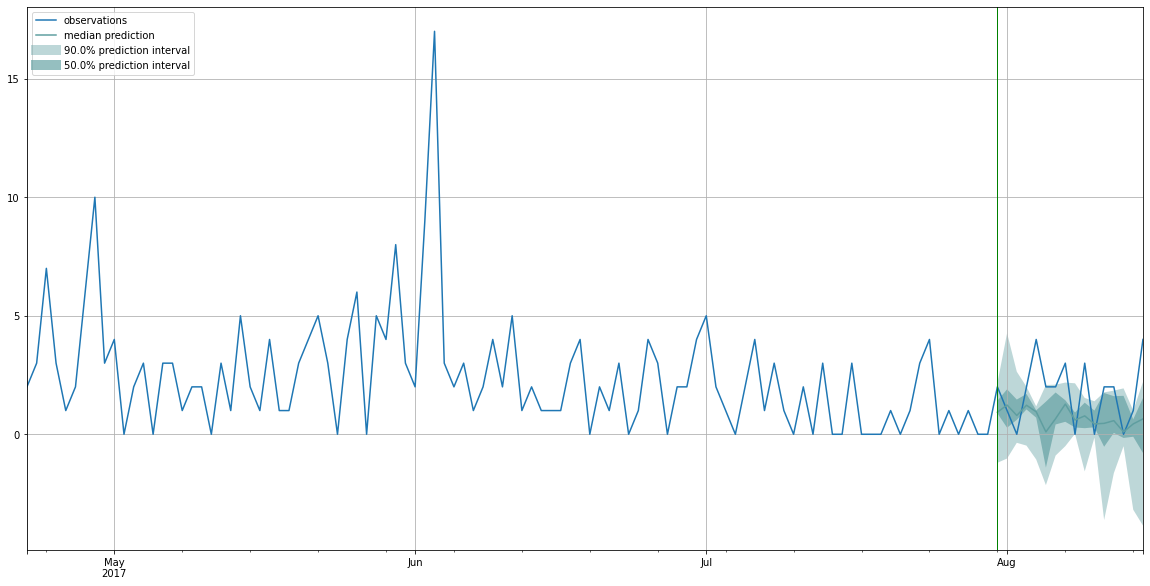

In [47]:
plot_prob_forecasts(
    all_stores_forecasts[1]['tss'][0],
    all_stores_forecasts[1]['forecasts'][0],
    prediction_length,
    (context_length-1900)
)

In [48]:
metrics = gluonts_metrics(all_stores_forecasts[1]['tss'], all_stores_forecasts[1]['forecasts'])
print(json.dumps(metrics, indent=4))

Running evaluation: 33it [00:00, 36.71it/s]

{
    "MSE": 22435.522499937,
    "abs_error": 25396.21622312069,
    "abs_target_sum": 114829.0,
    "abs_target_mean": 217.47916666666666,
    "seasonal_error": 42.16946847287961,
    "MASE": Infinity,
    "MAPE": 0.6309815243772884,
    "sMAPE": 0.8254524853193399,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 9573.704939500058,
    "Coverage[0.1]": 0.09659090909090909,
    "QuantileLoss[0.5]": 25396.21601555962,
    "Coverage[0.5]": 0.3333333333333333,
    "QuantileLoss[0.9]": 20461.2300417047,
    "Coverage[0.9]": 0.6496212121212122,
    "RMSE": 149.78492080291994,
    "NRMSE": 0.6887322730664007,
    "ND": 0.22116552633150763,
    "wQuantileLoss[0.1]": 0.08337358105966314,
    "wQuantileLoss[0.5]": 0.221165524523941,
    "wQuantileLoss[0.9]": 0.1781886983401815,
    "mean_absolute_QuantileLoss": 18477.050332254792,
    "mean_wQuantileLoss": 0.16090926797459523,
    "MAE_Coverage": 0.14015151515151517,
    "OWA": NaN
}



/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [49]:
len(all_stores_forecasts)

54

In [50]:
mean_rmse = 0
all_rmse = {}
for index, store in enumerate(nb_stores):
    metrics = gluonts_metrics(all_stores_forecasts[index]['tss'], all_stores_forecasts[index]['forecasts'])
    # print(metrics['RMSE'])
    mean_rmse = mean_rmse + float(metrics['RMSE'])
    all_rmse[store-1] = metrics['RMSE']

rmse = mean_rmse / len(nb_stores)
print("mean RMSE: ", rmse)


Running evaluation: 33it [00:00, 36.47it/s]
Running evaluation: 33it [00:00, 37.42it/s]
Running evaluation: 33it [00:00, 37.05it/s]
Running evaluation: 33it [00:00, 37.51it/s]
Running evaluation: 33it [00:00, 37.48it/s]
Running evaluation: 33it [00:00, 37.12it/s]
Running evaluation: 33it [00:00, 36.45it/s]
Running evaluation: 33it [00:00, 37.12it/s]
Running evaluation: 33it [00:00, 36.77it/s]
Running evaluation: 33it [00:00, 37.33it/s]
Running evaluation: 33it [00:00, 37.91it/s]
Running evaluation: 33it [00:00, 37.97it/s]
Running evaluation: 33it [00:00, 37.82it/s]
Running evaluation: 33it [00:00, 37.65it/s]
Running evaluation: 33it [00:00, 36.84it/s]
Running evaluation: 33it [00:00, 36.69it/s]
Running evaluation: 33it [00:00, 36.92it/s]
Running evaluation: 33it [00:00, 37.05it/s]
Running evaluation: 33it [00:00, 37.06it/s]
Running evaluation: 33it [00:00, 37.14it/s]
Running evaluation: 33it [00:00, 37.79it/s]
Running evaluation: 33it [00:00, 37.35it/s]
Running evaluation: 33it [00:00,

mean RMSE:  287.4305003151348


In [51]:

all_rmse
print("{:>10} {:>10}".format('STORE', 'RMSE'))
for value in all_rmse.items():
    store, rmse = value
    print("{:>10} {:>10}".format(store, rmse))

{0: 206.03225411304695,
 9: 149.78492080291994,
 10: 611.8867544328543,
 11: 142.95380444590216,
 12: 174.04719592177022,
 13: 242.02428100199728,
 14: 124.18104147867406,
 15: 128.27002666795482,
 16: 162.86232063240857,
 17: 197.65463972658992,
 18: 119.94755465970594,
 1: 185.62325098306258,
 19: 544.1316703122477,
 20: 310.9257486800544,
 21: 155.59745530541028,
 22: 111.39106680183139,
 23: 195.20445564975572,
 24: 315.32471201681875,
 25: 120.31293418685175,
 26: 196.42382774447248,
 27: 489.39852995641786,
 28: 261.9554720602192,
 2: 358.6166789501149,
 29: 213.2833183555069,
 30: 287.60593124863584,
 31: 187.42647166005517,
 32: 234.7980883483064,
 33: 148.74907657277407,
 34: 137.10291981661393,
 35: 360.3346641146554,
 36: 260.95805436708906,
 37: 394.3344362404673,
 38: 400.39774993920787,
 3: 176.16187882410344,
 39: 450.04953231517914,
 40: 255.76147603641678,
 41: 232.45822841087713,
 42: 282.0978982498041,
 43: 565.8717020572423,
 44: 436.21045076776716,
 45: 461.5825900

     STORE       RMSE
         0 206.03225411304695
         9 149.78492080291994
        10 611.8867544328543
        11 142.95380444590216
        12 174.04719592177022
        13 242.02428100199728
        14 124.18104147867406
        15 128.27002666795482
        16 162.86232063240857
        17 197.65463972658992
        18 119.94755465970594
         1 185.62325098306258
        19 544.1316703122477
        20 310.9257486800544
        21 155.59745530541028
        22 111.39106680183139
        23 195.20445564975572
        24 315.32471201681875
        25 120.31293418685175
        26 196.42382774447248
        27 489.39852995641786
        28 261.9554720602192
         2 358.6166789501149
        29 213.2833183555069
        30 287.60593124863584
        31 187.42647166005517
        32 234.7980883483064
        33 148.74907657277407
        34 137.10291981661393
        35 360.3346641146554
        36 260.95805436708906
        37 394.3344362404673
        38 400.397749939207

# Links 


### GluonTS multivariate :

<https://github.com/awslabs/gluonts/issues/494>

<https://github.com/awslabs/gluonts/issues/517>

<https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html>


### Interesting kaggle notebooks:

<https://www.kaggle.com/competitions/store-sales-time-series-forecasting/discussion/332439>

Google Search, prize of $125'000 : <https://www.kaggle.com/competitions/g-research-crypto-forecasting>

Notebook with GluonTs : <https://www.kaggle.com/code/steverab/m5-forecast-compet-uncert-gluonts-template>

With StatsModel / ARIMA : <https://www.kaggle.com/code/rodmnzs/store-sales-time-series-forecasting-pt-br>

Time series explained : seasonality, lag : <https://www.kaggle.com/code/ryanholbrook/time-series-as-features/tutorial> + template to apply this method : <https://www.kaggle.com/code/vincentjuge/exercise-time-series-as-features/edit>

